# Zihao's architecutre

Dec 2018

Ok, so we're in the middle of a retraining campaign right now, and one of the things that Rafael wanted me to look at was how the 
- different inputs
- normalization sheme

impacted the rnn performance

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
%%bash
python -m json.tool ../../ZihaoArch.json

{
    "class_name": "Sequential",
    "keras_version": "1.1.0",
    "config": [
        {
            "class_name": "Merge",
            "config": {
                "layers": [
                    {
                        "class_name": "Masking",
                        "config": {
                            "batch_input_shape": [
                                null,
                                15,
                                4
                            ],
                            "trainable": true,
                            "mask_value": 0,
                            "name": "masking_1",
                            "input_dtype": "float32"
                        }
                    },
                    {
                        "class_name": "Embedding",
                        "config": {
                            "trainable": true,
                            "name": "embedding_1",
                            "activity_regularizer": null,
                  

To study the comparisons of the R&D that I've been doing with the studies that Zihao did, I trained two models with Zihao's architecture on a ttbar sample: one w/ Topo and the other with PFlow jets. I'm going to compare against both of them (for now) so that I can see what the impact they are having.

**What changed??**
1. Different inputs (need to use different variable strings and different # of features)
2. Embedding layer
3. Dense layer

In [3]:
jetCollections = ['Topo','PFlow']
jetColors = [['C0','C1'],['C6','C2']]

In [4]:
modelConfig = [('sd0_sz0_ptfrac_dr_ip3d_grade',0,True),
               ('sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits',10,False)]

labels = ['previous setup','current setup']

**Need to remember to remake the test files on mc16d with PFlow!!!**

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


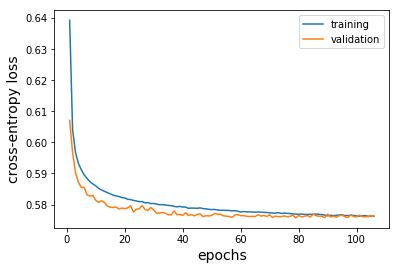

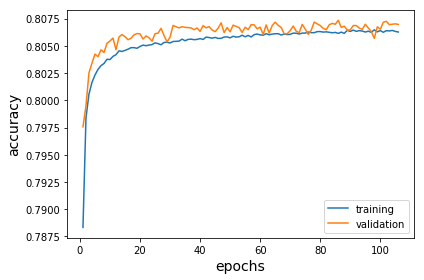

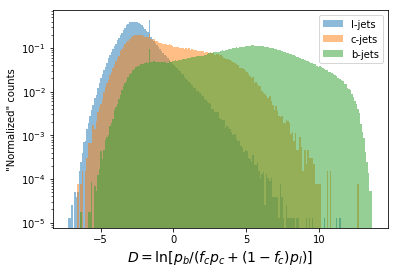

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


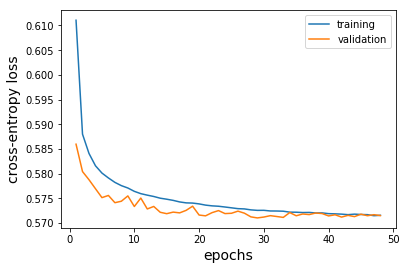

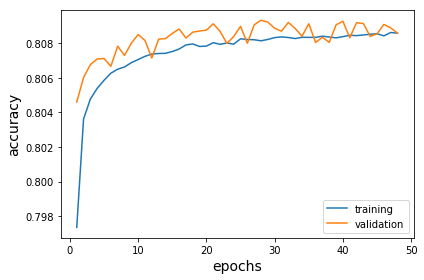

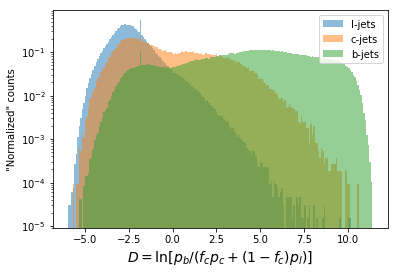

../../plottingFcts.py:479: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


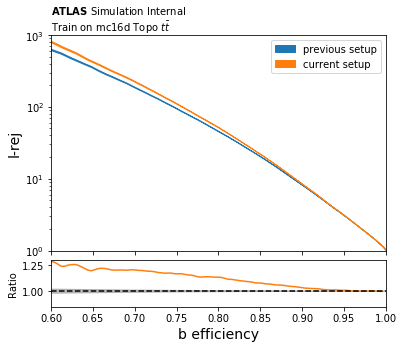

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


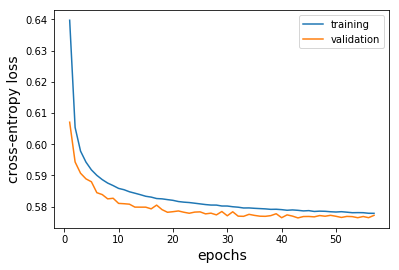

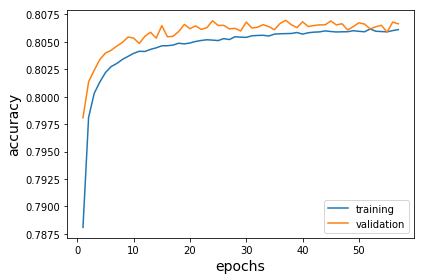

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


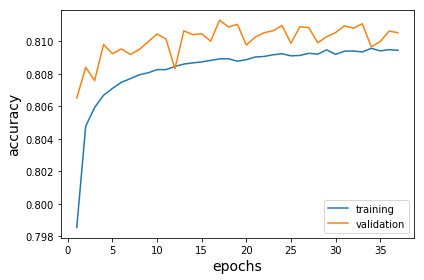

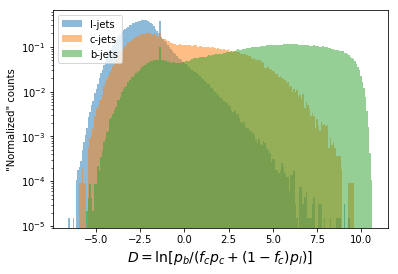

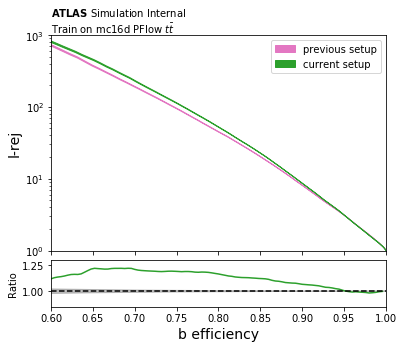

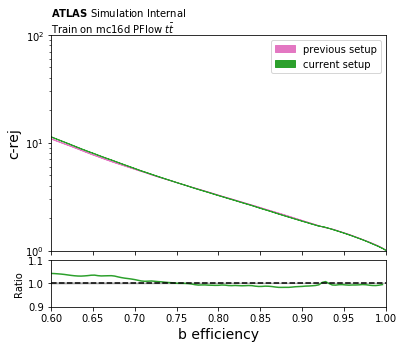

In [5]:
leffs, ceffs, beffs = [], [], []

figDir='../../figures'

for jetCollection,colors in zip(jetCollections,jetColors):
    
    subDir = 'mc16d_{}_ttbar'.format(jetCollection)
    dataDir = '../../data/'+subDir
    
    text = "$\mathbf{ATLAS}$ Simulation Internal\n"
    text+="Train on mc16d "+ jetCollection + r" $t\bar{t}$"
    
    for vStr, nDense, doEmbedding in modelConfig:
    
        # Step 1: Open the file
        dataTagTest = "2mtest_15trks_{}_sd0_rev".format(vStr)
        dataTagTrain = "3mtrain_15trks_{}_sd0_rev".format(vStr)

        f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)

        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        nTest = X.shape[0]
        
        # Step 2: Get the model
        modelDir = '../../models/'+subDir
        nFeatures = X.shape[-1]
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=dataTagTrain, loadModel=True,
                   nDense=nDense,doEmbedding=doEmbedding)
        trainingMetrics(m.modelName,modelDir=modelDir)

        # Step 3: Get the discriminant
        leff, ceff, beff = sigBkgEff(m, X, y, ix, figDir=figDir, subDir=subDir)
        
        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)
        
    # Make the roc curve with the comparison
    subTag='_cf_Zihao_setup'
    plotROCRatio(beffs[-2:], leffs[-2:], labels, rrange=(0.85,1.3),
                 text=text,ylabel='l-rej',binomialErrors=True,nTest=nTest, 
                 colors=colors,figDir=figDir, subDir=subDir,tag='lrej'+subTag)

    plotROCRatio(beffs[-2:], ceffs[-2:], labels, rrange=(0.9,1.10),ymax=100,
                 text=text,ylabel='c-rej',binomialErrors=True,nTest=nTest, 
                 colors=colors,figDir=figDir, subDir=subDir,tag='crej'+subTag)